In [84]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import math

# Step 1: Generate the data 
I'm aiming to generate 20000 datapoints from a Gaussian mixture model of k = 100 components. For simplicity, each datapoint is a scalar (1-dimension). 
To make it more realistic, I will random the weight of each component.

In [85]:
n = 50000 # Number of datapoints
k = 20 # Number of components

# Randomising the weights
weights = np.random.random(size=(k, ))
weights = weights / np.sum(weights) 
assert abs(np.sum(weights) - 1) < 0.0000001 # Ensuring a convex linear combination

# Decide which component we will sample from
mixture_index = np.random.choice(k, size = n, replace = True, p = weights)
assert mixture_index.shape == (n, )

# Decide the random mean and variance of all 100 components
mean = np.random.uniform(low=-20.0, high=20.0, size=(k, ))
variance = np.random.uniform(low=0, high=2.0, size=(k, ))


In [86]:
# Generate data using numpy for efficiency
data = np.fromiter((np.random.normal(loc = mean[index], scale = np.sqrt([variance[index]])[0]) for index in mixture_index), float)
assert data.shape == (n, )

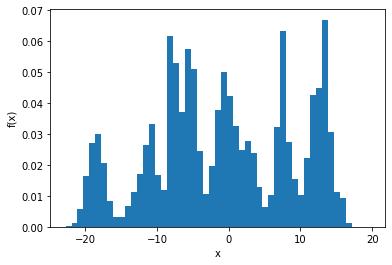

In [87]:
plt.hist(data, bins="auto", density=True)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.show()

# Step 2: The traditional EM algorithm
The algorithm includes finding the probability of each point belonging to each component, then tune the mean and variance of each component according the the calculated probabilities. 

In [88]:
# First, define a way to calculate pdf 
def pdf(x, mean, var):
    assert var >= 0
    return math.exp(-0.5 * ((x - mean) ** 2 ) / var) / (math.sqrt(2 * math.pi * var))

# Test the function
assert pdf(0, 0, 1) == 0.3989422804014327
assert pdf(0.5, 0, 1) == 0.3520653267642995


In [89]:
# Define a metric to evaluate our return from EM alg.
# KL divergence is an integral from -inf to +inf, in this case, I only use the n datapoints that we already generated.
def KL_div(pred_mean, pred_var, pred_weights):
    KL_divergence = 0
    for i in range(n):
        P_value = 0
        Q_value = 0
        for j in range(k):
            Q_value += pred_weights[j] * pdf(data[i], pred_mean[j], pred_var[j])
            P_value += weights[j] * pdf(data[i], mean[j], variance[j])
        KL_divergence += P_value * math.log(P_value/Q_value, math.e) 
    
    return KL_divergence
assert KL_div(mean, variance, weights) == 0

In [91]:
# This implementation is based on Dr. Martha White's notes for CMPUT367, page 107. 

def traditional_EM():
    predicted_mean = np.random.uniform(low=-5, high=5, size=(k, ))
    predicted_variance = np.random.uniform(low=0, high=5, size=(k, ))
    predicted_weights = np.random.random(size=(k, ))
    predicted_weights = predicted_weights / np.sum(predicted_weights) 
    
    divergence_plot = []
    
    KL_divergence = KL_div(predicted_mean, predicted_variance, predicted_weights)
    print("kl div:", KL_divergence)
    
    prev_divergence = math.inf
    
    while abs(prev_divergence - KL_divergence) > 0.001:
        
        prev_divergence = KL_divergence
        
        probability_matrix = np.zeros((n, k))
        normalised_p_matrix = np.zeros((n, k))
        for i in range(n):
            denominator_sum = 0
            for j in range(k):
                probability_matrix[i, j] = predicted_weights[j] * pdf(data[i], predicted_mean[j], predicted_variance[j])
                denominator_sum += probability_matrix[i, j]
            probability_matrix[i, :] = probability_matrix[i, :] / denominator_sum
        
        
        for j in range(k):
            normalised_p_matrix[:, j] = probability_matrix[:, j] / np.sum(probability_matrix[:, j])
                
        #print(predicted_mean)
        for j in range(k):
            predicted_weights[j] = (1/n) * np.sum(probability_matrix[:, j])
            predicted_mean[j] = np.sum(normalised_p_matrix[:, j] * data)
            
            predicted_variance[j] = np.sum(normalised_p_matrix[:, j] * (data - predicted_mean[j]) ** 2)
            
        assert predicted_variance.all() > 0
        assert abs(np.sum(predicted_weights) - 1) < 0.0000001
        
        KL_divergence = KL_div(predicted_mean, predicted_variance, predicted_weights)
        print("kl div:", KL_divergence)
        divergence_plot.append(KL_divergence)
        
    return predicted_mean, predicted_variance, predicted_weights, divergence_plot


predicted_mean, predicted_variance, predicted_weights, plot = traditional_EM()
print(predicted_mean, predicted_variance, predicted_weights)
print(mean, variance, weights)


kl div: 9626.561061547314
kl div: 802.2360026898185
kl div: 728.8721952829864
kl div: 686.83608491465
kl div: 659.1041483066837
kl div: 636.7145822582945
kl div: 609.1666940485426
kl div: 564.6694646549954
kl div: 499.5677355859708
kl div: 429.1641691084859
kl div: 371.71037814501574
kl div: 331.5723148741771
kl div: 305.9590388928763
kl div: 290.51105970871373
kl div: 281.43410518384684
kl div: 276.03163766448074
kl div: 272.621928996262
kl div: 270.25729715301543
kl div: 268.43329567400644
kl div: 266.88198213564436
kl div: 265.4516381854895
kl div: 264.04329878418076
kl div: 262.57786245499017
kl div: 260.9777738731951
kl div: 259.1549369926828
kl div: 257.0010657191918
kl div: 254.37947992929423
kl div: 251.11980618662832
kl div: 247.02051961005714
kl div: 241.87024155518145
kl div: 235.50687662007465
kl div: 227.9339288824112
kl div: 219.47429716746768
kl div: 210.83912893425943
kl div: 202.9340898939607
kl div: 196.4491035655143
kl div: 191.59122037115478
kl div: 188.164855354695

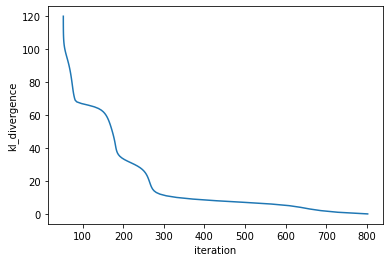

In [92]:
plt.plot(plot, [i for i in range(len(plot))])
plt.xlabel("iteration")
plt.ylabel("kl_divergence")
plt.show()